In [6]:
import numpy as np
import matplotlib.pyplot as plt
from glmpca import glmpca

import os
import sys
import pandas as pd
from scipy import sparse
import pickle
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from scipy.stats import betabinom
from scipy.optimize import minimize

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 

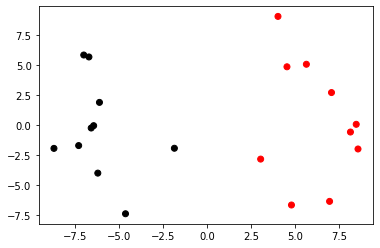

In [5]:
np.random.seed(123)

mu= np.exp(np.random.randn(20,100))
mu[range(10),:] *= np.exp(np.random.randn(100))
clust= np.repeat(["red","black"],10)
Y= np.random.poisson(mu)
res= glmpca.glmpca(Y.T, 2)
factors= res["factors"]
plt.scatter(factors[:,0],factors[:,1],c=clust)
plt.show()

In [8]:
res

{'factors': array([[ 4.55806818,  4.88048244],
        [ 4.04696012,  9.07541836],
        [ 8.59793142, -1.96394187],
        [ 5.66199983,  5.09097193],
        [ 7.09090578,  2.73440574],
        [ 3.06138807, -2.80594561],
        [ 8.4966949 ,  0.09007863],
        [ 4.81394746, -6.62921633],
        [ 6.98113724, -6.32637278],
        [ 8.16833122, -0.55262835],
        [-6.20036047, -3.97391817],
        [-6.99912111,  5.86095999],
        [-6.57606667, -0.21783544],
        [-7.2892386 , -1.68025249],
        [-1.84502997, -1.90356366],
        [-8.6945453 , -1.91397189],
        [-6.70537293,  5.69956802],
        [-6.43651784, -0.02274327],
        [-4.62499938, -7.35737141],
        [-6.10611195,  1.91587617]]),
 'loadings': array([[-1.60772073e-01,  3.34648465e-02],
        [-2.64819230e-01,  1.78046251e-01],
        [ 1.69289376e-01, -9.73341209e-02],
        [-9.89372593e-03,  1.69118453e-01],
        [-1.22330178e-01, -4.35108022e-02],
        [ 9.33780643e-03, -4.400983

"""
  GLM-PCA
  This function implements the GLM-PCA dimensionality reduction method for high-dimensional count data.
  The basic model is R = AX'+ZG'+VU', where E[Y]=M=linkinv(R). Regression coefficients are A and G, latent factors are U, and loadings are V. The objective function being optimized is the deviance between Y and M, plus an L2 (ridge) penalty on U and V. Note that glmpca uses a random initialization, so for fully reproducible results one should set the random seed.
  
  Parameters
  ----------
  Y: array_like of count data with features as rows and observations as
    columns.
  L: the desired number of latent dimensions (integer).
  fam: string describing the likelihood to use for the data. Possible values include:
  - poi: Poisson
  - nb: negative binomial
  - mult: binomial approximation to multinomial
  - bern: Bernoulli
  ctl: a dictionary of control parameters for optimization. Valid keys:
  - maxIter: an integer, maximum number of iterations
  - eps: a float, maximum relative change in deviance tolerated for convergence
  - optimizeTheta: a bool, indicating if the overdispersion parameter of the NB
    distribution is optimized (default), or fixed to the value provided in nb_theta.
  penalty: the L2 penalty for the latent factors (default = 1).
    Regression coefficients are not penalized.
  verbose: logical value indicating whether the current deviance should
    be printed after each iteration (default = False).
  init: a dictionary containing initial estimates for the factors (U) and
    loadings (V) matrices.
  nb_theta: negative binomial dispersion parameter. Smaller values mean more dispersion
    if nb_theta goes to infinity, this is equivalent to Poisson
    Note that the alpha in the statsmodels package is 1/nb_theta.
    If ctl["optimizeTheta"] is True, this is used as initial value for optimization
  X: array_like of column (observations) covariates. Any column with all
    same values (eg. 1 for intercept) will be removed. This is because we force
    the intercept and want to avoid collinearity.
  Z: array_like of row (feature) covariates, usually not needed.
  sz: numeric vector of size factors to use in place of total counts.

Returns
  -------
  A dictionary with the following elements
  - factors: an array U whose rows match the columns (observations) of Y. It is analogous to the principal components in PCA. Each column of the factors array is a different latent dimension.
  - loadings: an array V whose rows match the rows (features/dimensions) of Y. It is analogous to loadings in PCA. Each column of the loadings array is a different latent dimension.
  - coefX: an array A of coefficients for the observation-specific covariates array X. Each row of coefX corresponds to a row of Y and each column corresponds to a column of X. The first column of coefX contains feature-specific intercepts which are included by default.
  - coefZ: a array G of coefficients for the feature-specific covariates array Z. Each row of coefZ corresponds to a column of Y and each column corresponds to a column of Z. By default no such covariates are included and this is returned as None.
  - dev: a vector of deviance values. The length of the vector is the number of iterations it took for GLM-PCA's optimizer to converge. The deviance should generally decrease over time. If it fluctuates wildly, this often indicates numerical instability, which can be improved by increasing the penalty parameter.
  - glmpca_family: an object of class GlmpcaFamily. This is a minor wrapper to the family object used by the statsmodels package for fitting standard GLMs. It contains various internal functions and parameters needed to optimize the GLM-PCA objective function. For the negative binomial case, it also contains the final estimated value of the dispersion parameter nb_theta.
  Examples

In [12]:
print(Y.T.shape)
print(res["coefX"].shape)


(100, 20)
(100, 1)


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
n = 1000
p = 1200 ## make this larger to increase difficulty
n_top = 20 ## number of top words in each topic
k = 3
doc_len = 80
np.random.seed(123)

X, Atrue, Ftrue, p0, Ltrue = smallsim_independent(n = n, p = p, k = k, doc_len = doc_len, 
                                           n_top = n_top, returnL=True)
w_idx = np.where(X.sum(axis = 0) > 0)[0]
X = X[:,w_idx]

Pi_true = Ltrue @ Ftrue.T

In [14]:
res2 = glmpca.glmpca(X, 5)

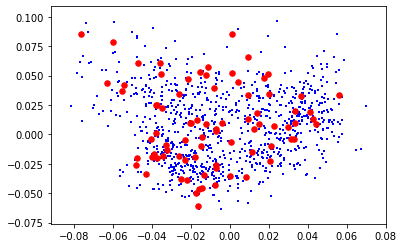

In [16]:
res2["loadings"].shape

vis_extremal_pca(res2["loadings"], [i for i in range(80)])

In [17]:
import time

In [21]:
n = 10000
A = np.random.normal(size = (n, n))
x = np.ones((n,1))
b = A @ x

a = time.time()
test= np.linalg.solve(A,b)
print(time.time() -a)

9.056680917739868
